# Índice
1. [Introducción](#Introducción)
2. [Métodos genéricos](#Métodos-genéricos)
3. [Ittens colors](#Ittens-colors)
4. [Color H](#Color-H)
5. [Testing](#Testing)
6. [Conclusiones](#Conclusiones)

<a id="introduccion"></a>
## Introducción
<p align="justify"> A lo largo de la historia del arte, todo artista se ha enfrentado a todo tipo de retos intentando transmitir el mensaje de su obra al público. Aunque áreas del conocimiento como anatomía, perspectiva o geometría son esenciales, el estudio de los colores en sí es un campo que ha sido difícil de estudiar. </p>

<p align="justify"> Han existido muchos tratados del color, siempre cambiantes junto con nuestra comprensión científica de la luz. Desde el primer estudio sobre el color de Aristóteles, asociado a los elementos (agua, tierra, fuego y aire) hasta la separación del espectro de luz visible de Isaac Newton, han surgido incontables maneras de relacionar colores entre sí. </p>

<p align="justify"> Es por esto que hoy en día un artista tiene a su disposición múltiples esquemas y gráficos que prometen hallar las mejores combinaciones de colores, cada uno basado en un principio diferente. </p>

<p align="justify"> Con este trabajo, nos proponemos explorar estas ruedas del color junto con sus bases científicas, ya sea digitalizando ruedas clásicas analógicas, o empleando diferentes algoritmos utilizados para los modelos más nuevos. </p>

<p align="justify"> Este trabajo resultará de una herramienta que analiza una imagen, detectando la paleta de colores actuales y ofreciendo una paleta nueva al detectar los colores principales y calcular sus complementarios en función de la rueda del color que elija el usuario. </p>


<a id="Métodos-genéricos"></a>
## Métodos Genéricos

In [3]:
import cv2
import matplotlib.pyplot as plt
from cv2.typing import *
import numpy as np
import matplotlib.patches as patches


def load_image(image_path: str):
    """Dada la ruta de la imágen, devuelve la imagen en RGBA

    Args:
        image_path (str): La ruta a la imagen
        
    Returns:
        La imagen en formato RGBA
    """
    
    image = cv2.imread(image_path,cv2.IMREAD_UNCHANGED)
    return cv2.cvtColor(image, cv2.COLOR_BGRA2RGBA)


def display_image(image: MatLike, title: str):
    """Dada una imagen y un título, muestra la imagen con el título especificado

    Args:
        image: La matriz de valores de una imagen en RGB(A) 
        title: Título de la imagen
    """
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')  # Turn off the axis

def split_alpha(image):
    """Dada una imagen, devuelve los canales RGB y el Alfa por separado

    Args:
        image: La imagen a separar sus canales

    Returns:
        rgb_image: Los canales RGB de la imagen
        alpha: El canal Alfa de la imagen
    """
    #rgb_image = cv2.cvtColor(image,cv2.COLOR_RGBA2RGB)
    rgb_image = image[:,:,:3]
    alpha = image[:,:,3]
    return rgb_image,alpha

def merge_alpha(image,alpha):
    """Dada una imagen en RGB y una matriz de su mismo tamaño con valores Alfa,
    devuelve la imagen en formato RGBA

    Args:
        image: La imagen en RGB
        alpha: La matriz del Alfa

    Returns:
        La imagen en RGBA
    """
    rgba_image = cv2.cvtColor(image,cv2.COLOR_RGB2RGBA)
    #rgba_image = np.resize(image,([*image.shape[:2],4]))
    #rgba_image[:,:,3]=alpha
    rgba_image = np.dstack((image,alpha))
    return rgba_image

def quantize_image(image: MatLike, n_colors):
    """Dada una imagen y el número de colores con la que quieres cuantizar,
    devuelve la misma imagen con sus colores cuantizados.

    Args:
        image: La imagen a cuantizar
        n_colors: El número de colores de la imagen resultante
        
    Returns:
        Imagen cuantizada con el número de colores especificados
    """
    Z = image.reshape((-1, 3))
    # convert to np.float32
    Z = np.float32(Z)
    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret, label, center = cv2.kmeans(
        Z, n_colors, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    final_image = res.reshape((image.shape))
    
    return final_image

In [4]:
def get_colors(image_array):
    """Dada una imagen, devuelve un diccionario que especifica
    la cantidad de cada color en la imagen

    Args:
        image_array: La imagen a medir

    Returns:
        colors (dict of (int, int, int):int): El diccionario con
        las cantidades de cada color en la imagen
    """
    colors = {}
    i = 0
    j = 0
    while i < image_array.shape[0]:
        while j < image_array.shape[1]:
            pixel = tuple(image_array[i, j])
            if pixel in colors:
                colors[pixel] = colors[pixel]+1
            else:
                colors[pixel] = 1
            j = j+1
        j = 0
        i = i+1
    return colors

In [5]:
blacklist = set()

In [6]:
def cambiar_colores(img: MatLike, paleta: dict):
    """img es la imagen original
    paleta es un diccionario donde las claves son los colores originales y los valores los colores por los que se van a sustituir en RGB
    """
    for color in paleta.keys():
        if color in blacklist:
            paleta[tuple(color)] = color
    
#    
#    i = 0
#    j = 0
#    while i < img.shape[0]:
#        while j < img.shape[1]:
#            
#            #print(paleta[tuple(img[i, j])])
#            img[i, j] = paleta[tuple(img[i, j])]                
#            j = j+1
#        j = 0
#        i = i+1
#    return img
    colors = get_colors(img)
    og_palette = list(colors.keys())
    new_im = img.copy()
    for og in og_palette:
        mask = cv2.inRange(img,np.array(og),np.array(og))
        new_im[mask > 0] = paleta[og]
    return new_im

<a id="Ittens-colors"></a>
## Ittens Colors
Contenido de la sección...

In [7]:
def build_ittens_colors(image: MatLike):
    """Dada la imagen de la paleta de colores Ittens, devuelve el diccionario
    correspondiente a su esquema de colores

    Cabe destacar que el diccionario comienza con el índice 1 en vez de 0

    Args:
        image: La imagen de Ittens

    Returns:
        ittens_colors (dict of int:list of (int, int, int)): El diccionario
        correspondiente al esquema de colores
    """
    ittens_colors = {}
    i = 1
    j = 1
    cut = (int(image.shape[1]/12),  int(image.shape[0]/12))
    start_point = [0, cut[0]]
    while i < 13:
        ittens_colors[i] = []
        while j < 13:
            y = start_point[0]
            x = start_point[1]
            cropped_image = image[y:y+cut[0], x:x+cut[1]]
            colors = get_colors(quantize_image(cropped_image, 1)).keys()
            first_color = next(iter(colors), None)
            if first_color is not None:
                ittens_colors[i].append(first_color)
            start_point[0] = start_point[0] + cut[0]
            j += 1
        j = 1
        start_point[0] = 0
        start_point[1] = start_point[1] + cut[1]
        i += 1
    return ittens_colors

In [8]:
ittens_image = load_image("images/Ittens Colors.png")
ittens_colors = build_ittens_colors(ittens_image[:,:,:3])
print(len(ittens_colors))

12


In [9]:
def get_color_value(ittens_colors: dict):
    """Dado un diccionario de un esquema de colores, muestra todos los colores
    del esquema, agrupados por tonalidad

    Args:
        ittens_colors (dict of int:list of (int, int, int)): diccionario del
        esquema de colores
    """
    for color in ittens_colors.keys():
        colors = ittens_colors.get(color)
        fig, ax = plt.subplots(1, 1, figsize=(10, 2))

        # Para cada color en la lista de colores
        for i, color in enumerate(colors):
            # Convertir el color de formato string a formato RGB
            rgb = color
            rgb = [c/255. for c in rgb]  # Normalizar a [0, 1]

            # Dibujar un rectángulo en el eje con el color correspondiente
            rect = patches.Rectangle((i, 0), 1, 1, facecolor=rgb)
            ax.add_patch(rect)

        # Configurar el eje
        ax.set_xlim(0, len(colors))
        ax.set_ylim(0, 1)
        ax.axis('off')  # Ocultar los ejes

        plt.show()

In [10]:
def show_color_palette(colors):
    """Dada una paleta de colores, muestra gráficamente
    los colores en ella

    Args:
        colors (list of (int, int, int)): La paleta de colores a
        mostrar
    """
    c = np.array(colors)/255
    fig,ax = plt.subplots()
    for i,color in enumerate(c):
        rect = patches.Rectangle((i,0),1,0.2,facecolor=color)
        ax.add_patch(rect)
    ax.set_xlim(0,len(colors))
    ax.set_ylim(0,0.2)
    ax.axis("off")

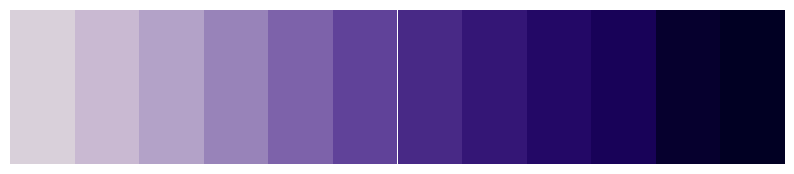

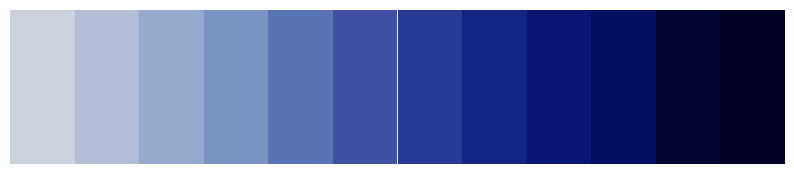

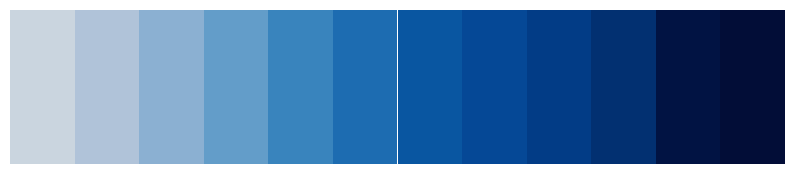

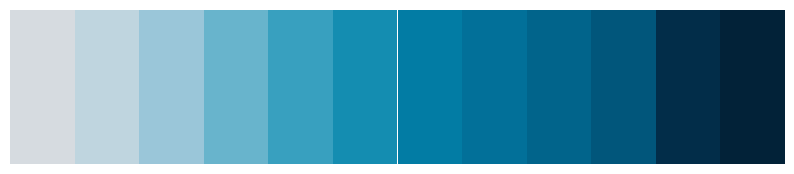

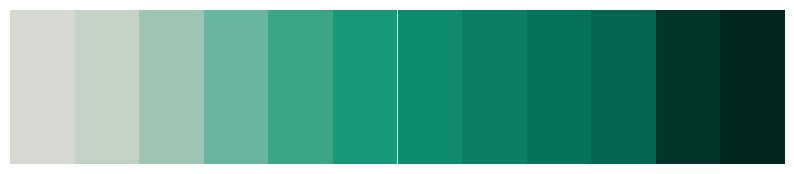

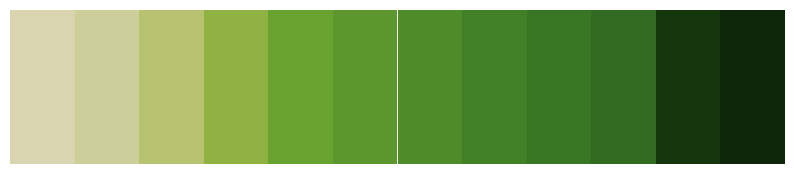

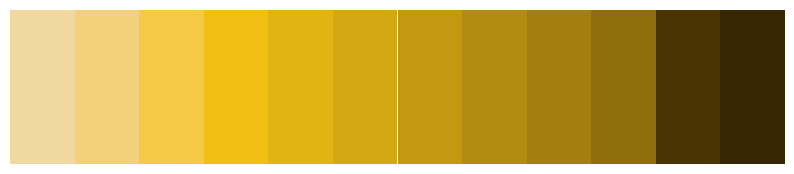

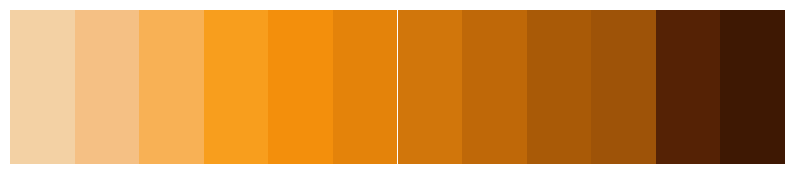

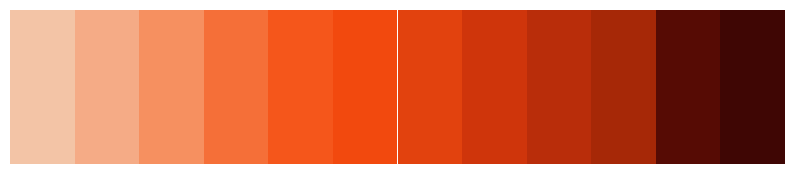

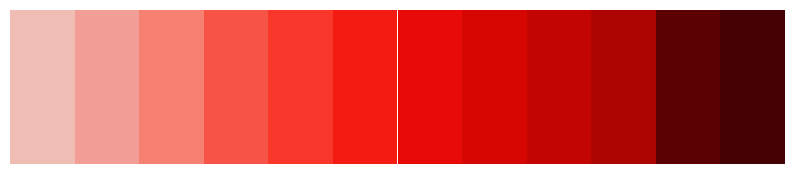

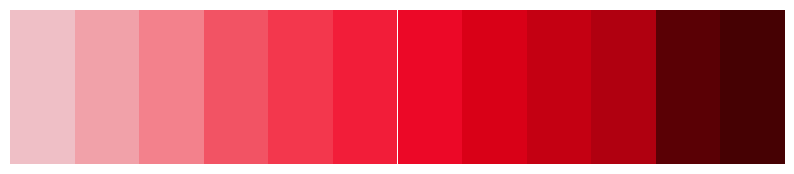

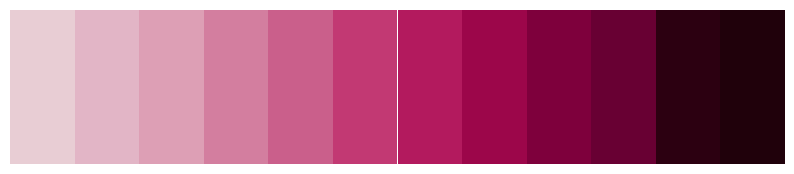

In [11]:
get_color_value(ittens_colors)

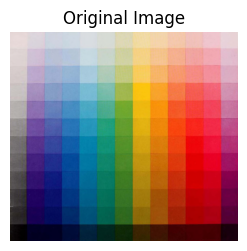

In [12]:
plt.figure(figsize=(10, 3))
plt.subplot(131)
display_image(load_image(image_path="images/Ittens Colors.png"),
              'Original Image')



In [13]:
def color_distance(c1,c2):
    """Dados dos tuplas o matrices de valores RGB, devuelve la distancia euclídea
    entre ellos

    Args:
        c1 (int, int, int):  El primer color en RGB
        c2 (int, int, int):  El segundo color en RGB

    Returns:
        d float: La distancia euclídea entre los dos colores
    """
    
    c1_i = np.array(c1).astype(int)
    c2_i = np.array(c2).astype(int)
    d = np.subtract(c1_i,c2_i)
    d = np.linalg.norm(d,axis=2)
    return d
    
def list_distance(n,pos1,pos2):
    """Dada la longitud de una lista y 2 posiciones en ella,
    devuelve la distancia entre ellas.

    Se considera que un elemento al inicio de la lista y otro al final
    tienen una distancia de 1.

    Args:
        n (int): Longitud de la lista
        pos1 (int): Primer índice de la lista
        pos1 (int): Segundo índice de la lista

    Returns:
        distance (int): Distancia entre las dos posiciones de la lista
    """
    
    distance = abs(pos1-pos2)
    return min(distance,n-distance)
    
def matrix_min_indexes(matrix):
    """Dada una matriz de valores numéricos, devuelve
    los índices necesarios para acceder al valor más pequeño

    Args:
        matrix: La matriz de la que obtener los índices

    Returns:
        indexes (int, int): Los índices para acceder al valor mínimo
    """

    min_index = np.argmin(matrix)
    (i1,i2) = np.unravel_index(min_index,matrix.shape)
    return (i1+1,i2)


def angle_to_index(angle, list_length) -> float:
    """Dado un ángulo en grados y una longitud de lista, devuelve el índice
    correspondiente al ángulo al tratar la lista como un círculo

    Args:
        angle (int): El ángulo en grados
        list_length (int): La longitud de lista
    Returns:
        index (int): El índice correspondiente al ángulo
    """

    return round(angle/360*list_length)


def rgb_to_hsv(rgb):
    """Dado una tupla de valor RGB, devuelve la correspondiente tupla en
    valores HSV

    Args:
        rgb (int, int, int): La tupla del valor RGB
    Returns:
        hsv (int, int, int): La tupla en valores HSV
    """
    to_convert = np.array([[rgb]],dtype=np.uint8)
    return cv2.cvtColor(to_convert,cv2.COLOR_RGB2HSV)[0][0]
    
def rgbs_to_hsv(rgbs):
    """Dada una lista de valores RGB, los convierte a HSV

    Args:
        rgbs (list of (int, int, int)): Lista de valores RGB
    Returns:
        hsv (list of (int, int, int)): Lista de valores HSV
    """
    to_convert = np.array([rgbs],dtype=np.uint8)
    return cv2.cvtColor(to_convert,cv2.COLOR_RGB2HSV)[0]


def group_hues(colors, n):
    """Dada una paleta de colores y un número n, agrupa los colores en
    n grupos según su tonalidad

    Args:
        colors (list of (int, int, int)): Los colores a agrupar
        n (int): El número de grupos a separar
    Returns:
        index_groups (list of lists of int): Los grupos, con cada color
            representado por su índice en la paleta
        color_groups (list of lists of (int, int, int)): Los grupos, con
        cada color representado por su valor RGB
        group_hues (list of int): Tonalidades medias de cada grupo
    """
    
    hues = [rgb_to_hsv(c)[0] for c in colors]
    hues = np.float32(hues)
    
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _,labels,centers = cv2.kmeans(hues, n, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    group_hues = centers
    labels = labels.flatten()
    
    groups = [hues[labels==i] for i in range(n)]
    index_groups = [np.arange(len(colors))[labels == i].tolist() for i in range(n)]
    color_groups = [np.array(colors)[labels==i].tolist() for i in range(n)]
    color_groups = [[tuple(c) for c in g] for g in color_groups]

    hue_mappings = {h:i for i,g in enumerate(groups) for h in g}
    color_mappings = {tuple(colors[i]):hue_mappings[hues[i]] for i in range(len(colors))}
    return index_groups, color_groups
    
def group_hues_threshold(colors,hue_threshold,color_scheme):
    """Dado un diccionario con cantidades de colores, una tolerancia de
    tonalidad y un esquema de colores, agrupa los colores según la tonalidad y
    su tolerancia, usando de referencia el esquema de colores.

    Una mayor tolerancia facilita que tonalidades más distintas se coloquen
    en un solo grupo.

    Args:
        colors (dict of (int, int, int):int): Las cantidades de colores en imagen
        hue_threshold: Tolerancia de agrupamiento de tonalidades
        color_scheme: El esquema de colores a usar de referencia

    Returns:
        groups (list of lists of (int, int)): Los grupos de tonalidades,
            representados por sus índices en el esquema de colores
        avg_hues (list of int): Tonalidades medias de cada grupo
        groups_quantities (list of int): Las cantidades de píxeles en la imagen
            por cada grupo
    """
    groups = []
    avg_hues = []
    groups_quantities = []
    palette = list(colors.keys())
    quantities = [colors[c] for c in palette]
    
    hues = find_closest_color(palette,color_scheme)
    hues = [t[0] for t in hues]
    
    available = list(range(len(palette)))
    while available:
        most_frequent = max(available,key=lambda i:colors[palette[i]])
        
        distances = [list_distance(len(color_scheme),hues[i],hues[most_frequent]) for i in available]
        
        group = list(filter(lambda i: distances[i]<=hue_threshold,range(len(available))))
        group = [available[i] for i in group]
        groups.append(group)
        
        group_quantity = sum([colors[palette[i]] for i in group])
        groups_quantities.append(group_quantity)

        avg_hue = round(sum([hues[i] for i in group])/len(group))
        avg_hues.append(avg_hue)
        
        available = list(filter(lambda i: i not in group,available))
    return groups, avg_hues, groups_quantities
    
def find_closest_color(color,color_scheme:dict):
    """
    Dada una tupla de un valor RGB y un esquema de colores, devuelve el índice
    del color más cercano en el esquema de colores al color especificado

    Args:
        color (int, int, int): El color a buscar
        color_scheme (dict of int:list of (int, int, int)): El esquema de 
            colores de referencia
    Returns:
        min_indices (int, int): Índices correspondientes al color más
            parecido en el esquema de colores
    """
    matrix = [color_scheme[key] for key in sorted(color_scheme)]
    min_indices = [matrix_min_indexes(color_distance(c,matrix)) for c in color]
    return min_indices
    
def convert_im_to_scheme(quantized_image,color_scheme):
    """Dada una imagen y un esquema de colores, devuelve la imagen corregida
    para ajustarse lo más posible a la paleta de colores.

    Args:
        quantized_image: La imagen a adaptar
        color_scheme: El esquema de colores a usar

    Returns:
        new_im: La imagen adaptada al esquema de colores
    """
    colors = get_colors(quantized_image)
    color_palette = list(colors.keys())
    indexes = find_closest_color(color_palette,ittens_colors)
    new_im = quantized_image.copy()

    for i,og in enumerate(color_palette):
        mask = cv2.inRange(quantized_image,np.array(og),np.array(og))
        ind = indexes[i]
        new_im[mask > 0] = color_scheme[ind[0]][ind[1]]
    return new_im
    
def convert_im_palette(quantized_image,color_palette):
    """Dada una imagen y una paleta con tantos colores como tenga la imagen,
    devuelve una imagen convertida a la paleta de colores especificada.

    Args:
        quantized_image: La imagen a transformar
        color_palette (list of (int, int, int)): La paleta de colores a usar
    Returns:
        new_im: La imagen con la nueva paleta de colores
    """
    colors = get_colors(quantized_image)
    og_palette = list(colors.keys())
    new_im = quantized_image.copy()
    for i,og in enumerate(og_palette):
        mask = cv2.inRange(quantized_image,np.array(og),np.array(og))
        new_im[mask > 0] = color_palette[i]
    return new_im

def complementary_palette(q_im, hue_tolerance, color_scheme):
    """Dada una imagen, una tolerancia de tonalidad y un esquema de colores,
    transforma la imagen convirtiendo los colores no dominantes al complementario
    del color dominante

    Args:
        q_im: Imagen a transformar
        hue_tolerance (int): Tolerancia de tonalidad al detectar tonalidad principal
        color_scheme: El esquema de colores a usar
    Returns: 
        image: Imagen transformada
    """
    colors = get_colors(q_im)
    palette = list(colors.keys())
    # Could find a way to remove this extra call to find_closest_color,
    # given that group_hues_threshold also calls it
    correct_palette = find_closest_color(palette, color_scheme)

    hue_groups, avg_hues, hue_quantities = group_hues_threshold(colors, hue_tolerance, color_scheme)

    max_hue_i = max(range(len(hue_groups)), key=lambda i: hue_quantities[i])
    max_hue = avg_hues[max_hue_i]

    complementary_hue = angle_to_index(180, len(color_scheme)) + max_hue
    complementary_hue = complementary_hue % len(color_scheme)

    to_modify_i = list(filter(
        lambda i: i not in hue_groups[max_hue_i],
        range(len(palette))
    ))

    new_palette = np.array(correct_palette[:])
    new_palette[to_modify_i, 0] = complementary_hue
    new_palette = [color_scheme[i][j] for i, j in new_palette]
    return convert_im_palette(q_im, new_palette)

def monochromatic_palette(q_im, hue_tolerance, color_scheme):
    """Dada una imagen, una tolerancia de tonalidad y un esquema de colores,
    convierte la imagen entera a la tonalidad dominante.

    Args:
        q_im: Imagen a transformar
        hue_tolerance (int): Tolerancia de tonalidad al detectar tonalidad principal
        color_scheme: El esquema de colores a usar
    Returns: 
        image: Imagen transformada
    """
    colors = get_colors(q_im)
    palette = list(colors.keys())

    correct_palette = find_closest_color(palette, color_scheme)

    hue_groups, avg_hues, hue_quantities = group_hues_threshold(colors, hue_tolerance, color_scheme)
    
    max_hue_i = max(range(len(hue_groups)), key=lambda i: hue_quantities[i])
    max_hue = avg_hues[max_hue_i]

    new_palette = np.array(correct_palette[:])
    new_palette[:,0] = max_hue
    new_palette = [color_scheme[i][j] for i, j in new_palette]
    return convert_im_palette(q_im, new_palette)

def split_complementary(q_im, hue_tolerance, hue_distance, color_scheme):
    """Dada una imagen, una tolerancia de tonalidad, una distancia de tonalidad
    y un esquema de colores, transforma la imagen convirtiendo los colores
    no dominantes a 2 colores a la distancia especificada del complementario
    del color dominante

    Args:
        q_im: Imagen a transformar
        hue_tolerance (int): Tolerancia de tonalidad al detectar tonalidad principal
        hue_distance (int): La distancia al color complementario a usar para los
            nuevos colores
        color_scheme: El esquema de colores a usar
    Returns: 
        image: Imagen transformada
    """
    colors = get_colors(q_im)
    palette = list(colors.keys())

    correct_palette = find_closest_color(palette, color_scheme)

    hue_groups, avg_hues, hue_quantities = group_hues_threshold(colors, hue_tolerance, color_scheme)
    
    max_hue_i = max(range(len(hue_groups)), key=lambda i: hue_quantities[i])
    max_hue = avg_hues[max_hue_i]

    remaining = [g for i,g in enumerate(hue_groups) if i!=max_hue_i]

    complementary_hue = angle_to_index(180, len(color_scheme)) + max_hue
    complementary_hue = complementary_hue % len(color_scheme)

    first_split = complementary_hue + hue_distance
    first_split = first_split % len(color_scheme) + 1 if first_split > len(color_scheme) else first_split

    second_split = complementary_hue - hue_distance
    second_split = second_split + len(color_scheme) if second_split < 1 else second_split

    new_palette = np.array(correct_palette[:])

    to_modify_i = list(filter(
        lambda i: i not in hue_groups[max_hue_i],
        range(len(palette))
    ))

    for index in to_modify_i:
        new_palette[index][0] = first_split if index % 2 == 0 else second_split

    print("Complementary", complementary_hue)
    print("Splits", first_split, second_split)
    new_palette = [color_scheme[i][j] for i,j in new_palette]
    
    return convert_im_palette(q_im, new_palette)


# Aplicación a un diseño de personaje

## Diseño original

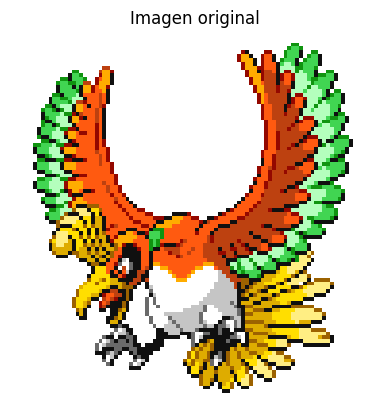

In [14]:
rgba = load_image("images/Ho-Oh.png")
image,alpha = split_alpha(rgba)
display_image(rgba,"Imagen original")

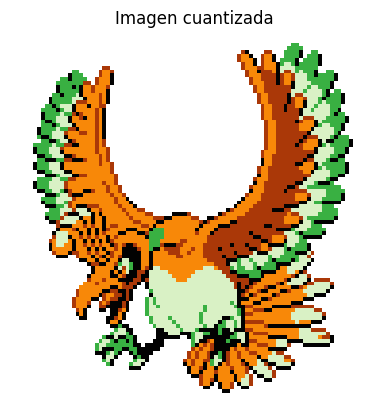

In [15]:
q_im = quantize_image(image,5)
display_image(merge_alpha(q_im,alpha),"Imagen cuantizada")

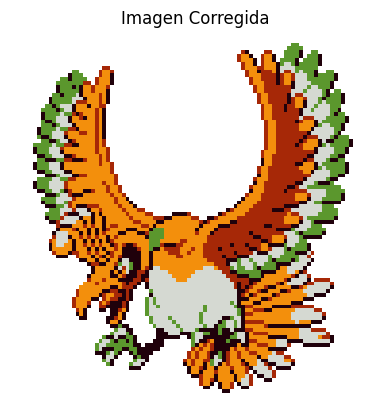

In [16]:
colors = get_colors(q_im)
color_palette = list(colors.keys())
indexes = find_closest_color(color_palette,ittens_colors)
new_colors = [ittens_colors[i][j] for i,j in indexes]

corrected = convert_im_palette(q_im,new_colors)
rgba_corrected = merge_alpha(corrected,alpha)
display_image(rgba_corrected,"Imagen Corregida")

## Retoque de paleta de colores

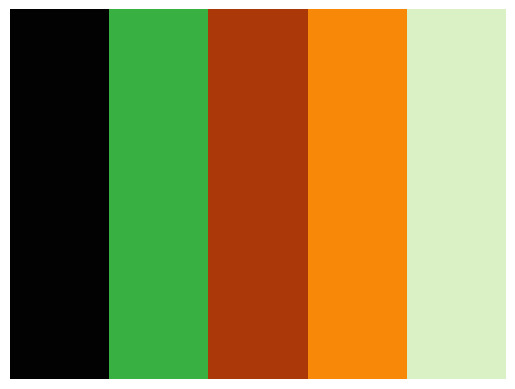

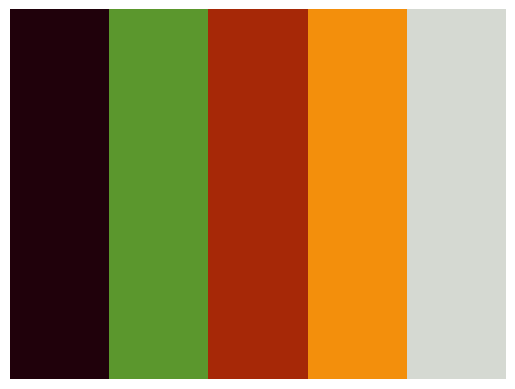

In [17]:
show_color_palette(color_palette)
show_color_palette(new_colors)

In [18]:
blacklist = set()
blacklist.add(color_palette[0])
print(color_palette)

[(2, 2, 2), (57, 176, 66), (170, 56, 8), (248, 136, 8), (217, 241, 197)]


In [19]:
# paleta = {}
# for i in range(len(color_palette)-1):
#     value = []
#     for j in new_colors[i]:
#         value.append(j)
#     paleta[tuple(color_palette[i])]=value
# 
paleta = {k:v for k,v in zip(color_palette,new_colors)}

print(paleta)


{(2, 2, 2): (32, 1, 11), (57, 176, 66): (91, 151, 45), (170, 56, 8): (166, 40, 7), (248, 136, 8): (243, 143, 12), (217, 241, 197): (213, 217, 210)}


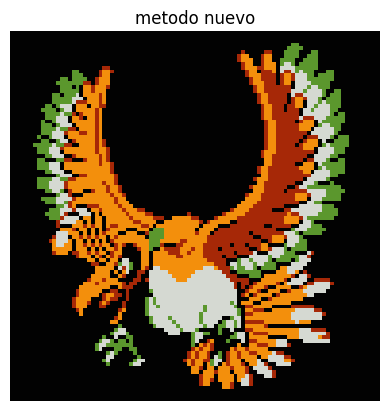

In [20]:
display_image(cambiar_colores(q_im, paleta), "metodo nuevo")

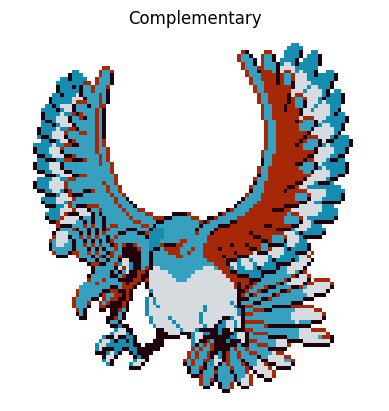

In [21]:
comp_im = complementary_palette(q_im,3,ittens_colors)
display_image(merge_alpha(comp_im,alpha),"Complementary")
#show_color_palette(new_palette)
#show_color_palette(list(get_colors(comp_im).keys()))

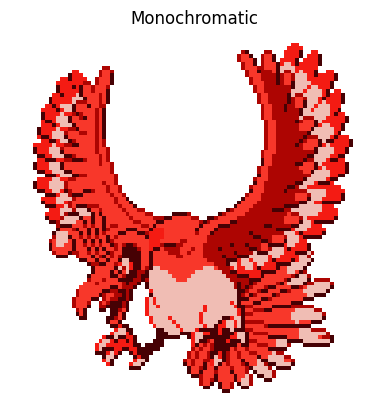

In [22]:
mono_im = monochromatic_palette(q_im,4,ittens_colors)
display_image(merge_alpha(mono_im,alpha),"Monochromatic")

Complementary 4
Splits 7 1


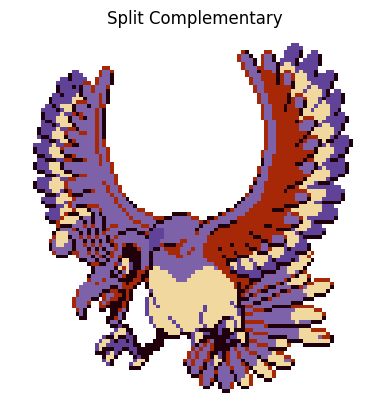

In [23]:
spl_im = split_complementary(q_im,3,3,ittens_colors)
display_image(merge_alpha(spl_im,alpha),"Split Complementary")

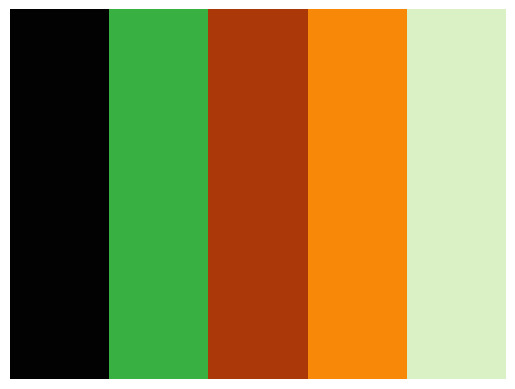

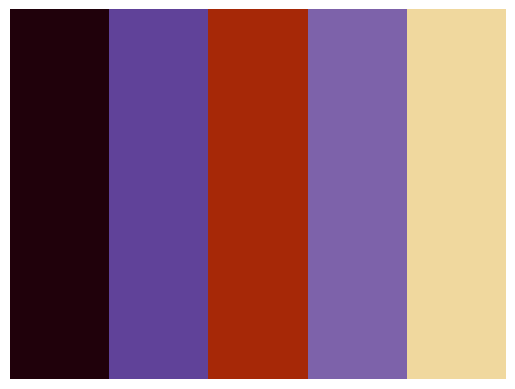

In [24]:
pal = list(get_colors(spl_im).keys())
show_color_palette(color_palette)
show_color_palette(pal)

1º: sacar los colores de la imagen original (get colors)
2º: construir un array con los colorores originales (array 1) traducidos de RGB a HSI
3º: de los colores originales nos quedamos con el primario en una variable
4º: a partir del color primario, calculamos una nueva paleta de colores sumado sobre el ángulo, generando un nuevo array (array 2)
5º: crear un método que sustituya los colores de la imagen comparando cada color de array 1 con los colores de array 2. Se asocia a cada color de array 1 el color más próximo de array 2.

<h1>Modelo hsv</h1>

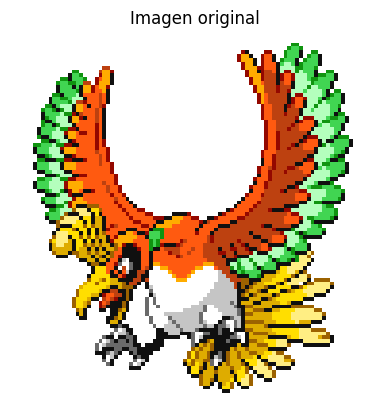

In [25]:
rgba = load_image("images/Ho-Oh.png")
image,alpha = split_alpha(rgba)
display_image(rgba,"Imagen original")

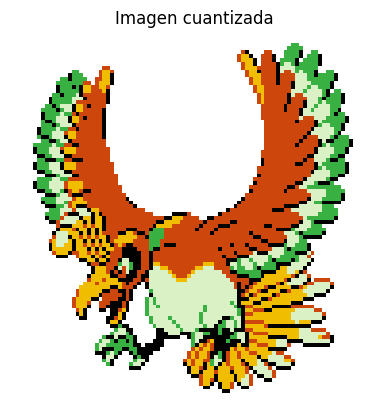

In [26]:
q_im = quantize_image(image,5)
display_image(merge_alpha(q_im,alpha),"Imagen cuantizada")

In [27]:
colors = get_colors(q_im)
color_palette = list(colors.keys())

print(color_palette)

[(2, 2, 2), (57, 176, 66), (205, 70, 11), (240, 189, 0), (217, 241, 197)]


In [36]:
def hsv_color_palette(rgb_pallete: list):
    hsv = []
    for color in rgb_pallete:
        pixel = np.uint8([[color]])
        hsv_color = cv2.cvtColor(pixel, cv2.COLOR_RGB2HSV)
        hsv.append(hsv_color[0][0])
    return hsv

In [43]:
hsv_color_pal = hsv_color_palette(color_palette)
print(hsv_color_pal)

[array([0, 0, 2], dtype=uint8), array([ 62, 172, 176], dtype=uint8), array([  9, 241, 205], dtype=uint8), array([ 24, 255, 240], dtype=uint8), array([ 46,  47, 241], dtype=uint8)]


In [45]:
def show_color_palette_hsv(hsv_colors):
    """Dada una paleta de colores en HSV, muestra gráficamente
    los colores en ella

    Args:
        hsv_colors (list of (int, int, int)): La paleta de colores a
        mostrar en formato HSV
    """
    rgb_colors = [cv2.cvtColor(np.uint8([[color]]), cv2.COLOR_HSV2RGB)[0][0] for color in hsv_colors]
    c = np.array(rgb_colors)/255
    fig,ax = plt.subplots()
    for i,color in enumerate(c):
        rect = patches.Rectangle((i,0),1,0.2,facecolor=color)
        ax.add_patch(rect)
    ax.set_xlim(0,len(hsv_colors))
    ax.set_ylim(0,0.2)
    ax.axis("off")

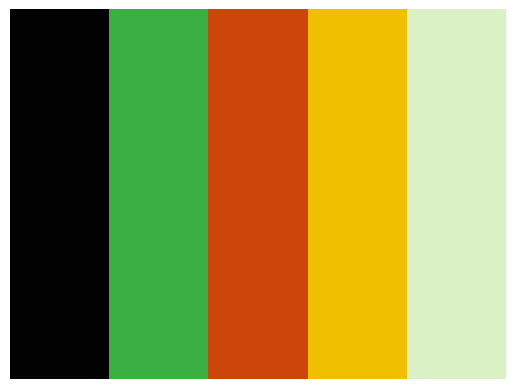

In [46]:
show_color_palette_hsv(hsv_color_pal)

In [ ]:
blacklist = set()
blacklist.add(color_palette[0])